In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from preprocessing_pipeline1 import DataPreprocessor

train_df = pd.read_csv("data/processed/train_engineered.csv")
val_df = pd.read_csv("data/processed/validation_engineered.csv")

# Separate features & target
X_train, y_train = train_df.drop(columns=["Attrition"]), train_df["Attrition"]
X_val, y_val = val_df.drop(columns=["Attrition"]), val_df["Attrition"]

print(X_train.head())
print(X_train.isnull().sum())

    Age  Gender  Years at Company  Monthly Income  Number of Promotions  \
0  56.0       1              38.0          4082.0                   0.0   
1  27.0       0               2.0          4540.0                   0.0   
2  51.0       0              36.0          9949.0                   3.0   
3  44.0       1              30.0          5058.0                   0.0   
4  33.0       1              19.0          4523.0                   1.0   

   Overtime  Distance from Home  Number of Dependents  Remote Work  \
0         0                64.0                   4.0            1   
1         0                95.0                   1.0            0   
2         0                43.0                   3.0            0   
3         1                76.0                   5.0            0   
4         1                18.0                   2.0            0   

   Leadership Opportunities  ...  Employee Recognition_High  \
0                         0  ...                        0.0   
1 

In [2]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_val, xgb_preds))
print(classification_report(y_val, xgb_preds))

/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:31:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
Accuracy: 0.7580244642692909
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      5681
           1       0.75      0.75      0.75      5192

    accuracy                           0.76     10873
   macro avg       0.76      0.76      0.76     10873
weighted avg       0.76      0.76      0.76     10873



In [3]:
segment_column = "Job Role"
preprocessor = DataPreprocessor()
preprocessor.load_data("data/processed/train.csv", "data/processed/validation.csv")
preprocessor.handle_missing_values()
preprocessor.feature_engineering()

segment_data = preprocessor.process_by_segment("Job Role")

models = {}
all_preds = []
all_true = []

for group, data in segment_data.items():
    print(f"\nTraining model for segment: {group}")

    model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model.fit(data["X_train"], data["y_train"])
    preds = model.predict(data["X_val"])

    models[group] = model

    all_preds.extend(preds)
    all_true.extend(data["y_val"])

# Final Evaluation
print("\nOverall Performance:")
print("Accuracy:", accuracy_score(all_true, all_preds))
print(classification_report(all_true, all_preds))

Handling missing values...
Missing values handled.
Adding engineered features...
Feature engineering done.
Processing data by segments in 'Job Role'...
  Segment: Education
  Segment: Technology
  Segment: Finance
  Segment: Healthcare
  Segment: Media
Segmentation-based processing complete.

Training model for segment: Education


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:31:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training model for segment: Technology


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:31:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training model for segment: Finance

Training model for segment: Healthcare


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:31:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:31:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training model for segment: Media


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:31:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Overall Performance:
Accuracy: 0.7455536912751678
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      6252
           1       0.73      0.73      0.73      5668

    accuracy                           0.75     11920
   macro avg       0.74      0.74      0.74     11920
weighted avg       0.75      0.75      0.75     11920



<Figure size 1000x1200 with 0 Axes>

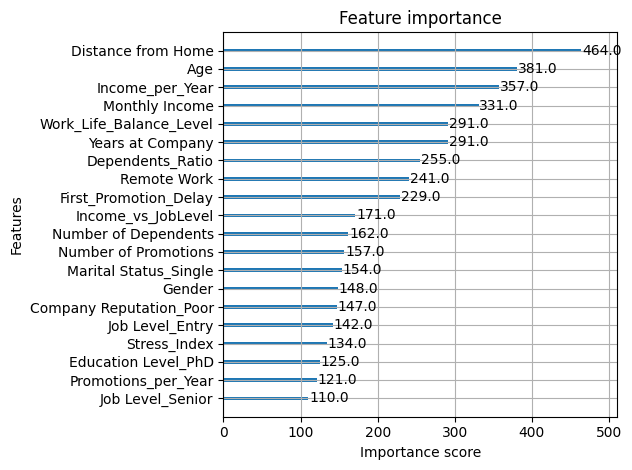

In [4]:
plt.figure(figsize=(10, 12))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.tight_layout()
plt.show()


In [5]:
preprocessor = DataPreprocessor()
preprocessor.load_data("data/processed/train.csv", "data/processed/validation.csv")
preprocessor.handle_missing_values()
preprocessor.feature_engineering()

segment_data_k_means = preprocessor.process_by_kmeans(n_clusters=4)

models = {}
all_preds = []
all_true = []

for cluster_id, data in segment_data_k_means.items():
    print(f"\nTraining model for Cluster {cluster_id}")

    model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model.fit(data["X_train"], data["y_train"])
    preds = model.predict(data["X_val"])

    models[cluster_id] = model

    all_preds.extend(preds)
    all_true.extend(data["y_val"])

print("\nOverall Results:")
print("Accuracy:", accuracy_score(all_true, all_preds))
print(classification_report(all_true, all_preds))


Handling missing values...
Missing values handled.
Adding engineered features...
Feature engineering done.
Clustering with KMeans (k=4)...
  Preparing cluster: 0
  Preparing cluster: 1
  Preparing cluster: 2
  Preparing cluster: 3
KMeans-based segmentation complete.

Training model for Cluster 0

Training model for Cluster 1


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:31:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:31:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training model for Cluster 2

Training model for Cluster 3


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:31:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:31:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Overall Results:
Accuracy: 0.7524328859060403
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      6252
           1       0.74      0.73      0.74      5668

    accuracy                           0.75     11920
   macro avg       0.75      0.75      0.75     11920
weighted avg       0.75      0.75      0.75     11920



<Figure size 1000x1200 with 0 Axes>

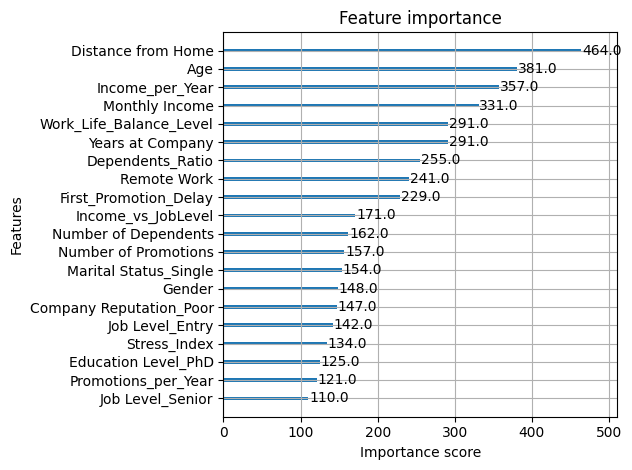

In [6]:
plt.figure(figsize=(10, 12))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.tight_layout()
plt.show()